# Frequency De-mixer: 'Unwanted Solo'

In [172]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter, freqz, firwin, tf2zpk, periodogram

- Analyzing the Frequency Charateristics of the audio file

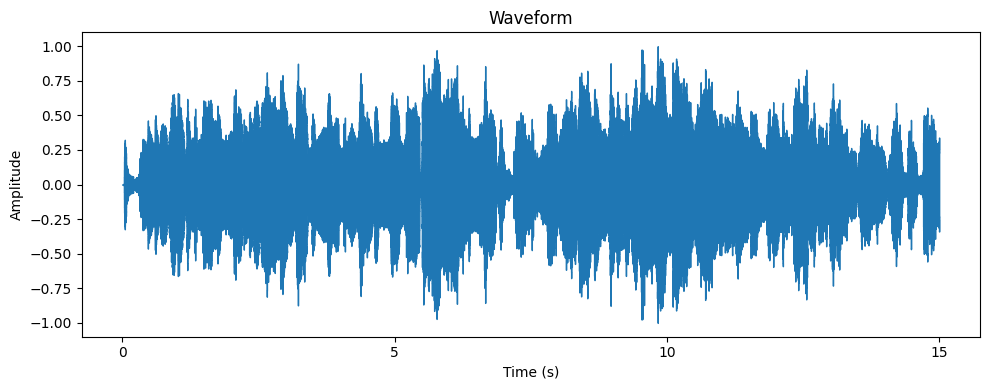

In [173]:
#Loading the audio file
audio_path = "song_with_2piccolo.wav"
y, sr = librosa.load(audio_path, sr=None, mono=True) # sr - sampling rate
# print(f"Sample Rate: {sr} Hz")
# print(f"Duration: {len(y) / sr:.2f} seconds")

y_normalized = y / np.max(np.abs(y))

#Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y_normalized, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

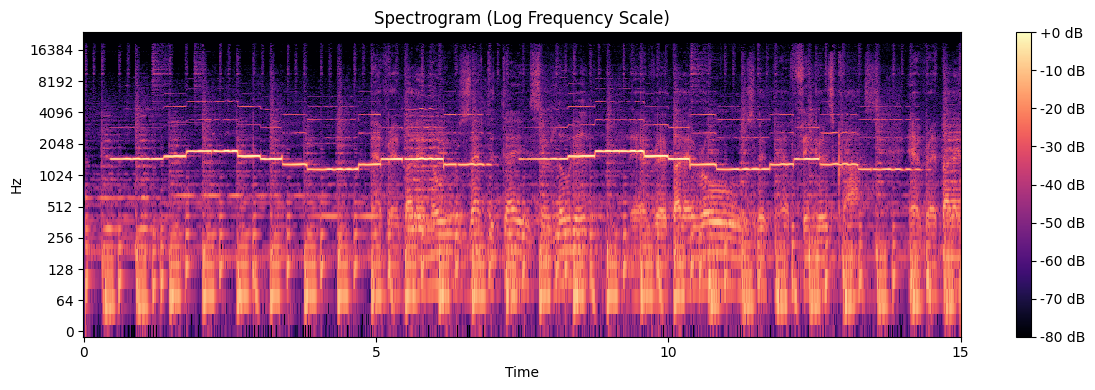

In [174]:
#Magnitude Spectrum
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (Log Frequency Scale)")
plt.tight_layout()
plt.show()

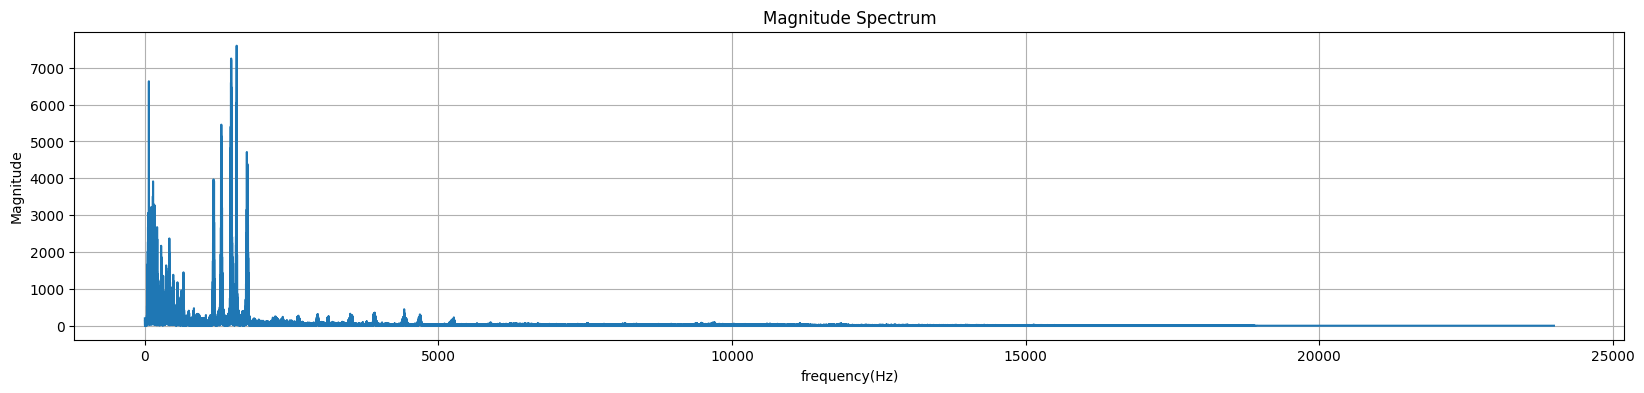

In [175]:
#Fourier Transform
n = len(y)
Y = np.fft.fft(y) 
freqs = np.fft.fftfreq(n, d=1/sr) #creating frequency bins for plotting

plt.figure(figsize=(20,4))
plt.plot(freqs[:len(freqs)//2],np.abs(Y)[:len(Y)//2])
plt.title("Magnitude Spectrum")
plt.xlabel('frequency(Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
# plt.xticks(np.arange(0, 25001, 500))

### Observations from Audio Analysis

#### 1. Time-Domain Waveform

- The waveform shows a complex mix of audio components with varying amplitudes over time.
- There are several prominent peaks that suggest the presence of loud, periodic elements, possibly corresponding to an unwanted instrumental solo overlaid on the original music.

#### 2. Spectrogram(Log Frequency Scale)

- The spectrogram (on a log frequency scale) visualizes how the audio energy is distributed over time and frequency.
- Most of the signal appears in shades of orange and yellow, indicating **moderate to low energy** across much of the spectrum.
- However, a **consistently bright and isolated horizontal band** is visible in the range of **1024 Hz to 2048 Hz** and active throughout the track displays relatively **higher intensity**.
- These characteristics—narrow frequency range and high intensity—indicate the presence of an **unwanted solo instrumental**.

#### 3. Frequency Domain (Magnitude Spectrum)

On increasing the number of markings on the frequency axis, following were obeserved:
  - **0 Hz to 100 Hz** depicting a **low-pitched** with significant energy standing out.
  - **100 Hz to 700 Hz** are dominated by low-energy components, likely corresponding to bass and lower vocal registers.
  - **Around 1000Hz** mid-frequency content, possibly harmonics or main vocal presence.
  - **1100 Hz to 1800 Hz** A strong, narrow, high-energy band is observed in this range, indicating a dominant, likely unwanted, solo instrumental component.

The band between **1100 Hz and 1800 Hz** stands out in sharp contrast to the surrounding frequencies and is a prime target for suppression.

**Note** : Designing filters considering Finite Impulse Response(FIR) rather than Infinite Impulse Response(IIR) to have sharp cuts and thus desired suppression.

In [176]:
#Testing audio based on above observations(frequency domain)
lowcut = 1100
highcut = 1800

nyq = 0.5 * sr
low = lowcut/nyq
high = highcut/nyq

#Using firwin from scipy.signal for FIR signals
numtaps = 1001  # Higher value indicates more filters and thus more precision(at some computational cost)
fir_coeffs = firwin(numtaps, [low,high], pass_zero='bandpass', window='blackman') #using window as 'blackman' for stronger attenuation

y_filtered = lfilter(fir_coeffs, 1.0, y)
sf.write('observe_4.wav', y_filtered*5, sr)

### Filter Design

In [177]:
#Pole-zero analysis
def pole_zero(b, a):
    z, p, k = tf2zpk(b, a)

    t = np.linspace(0, 2*np.pi, 1000)
    unit_circle = np.exp(1j*t)

    plt.figure(figsize=(6, 6))
    plt.plot(np.real(unit_circle), np.imag(unit_circle), 'k--', label='Unit Circle')
    plt.scatter(np.real(z), np.imag(z), c='blue', marker='o', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), c='red', marker='x', label='Poles')
    plt.title('Pole-Zero Plot')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

- Low Pass Filter

Keeping only the frequencies below the 1000 Hz mark to suppress the piccolo flute. This suppression comes at the cost of losing the frequecies higher than 1100 Hz mark but not containing the piccolo flute.

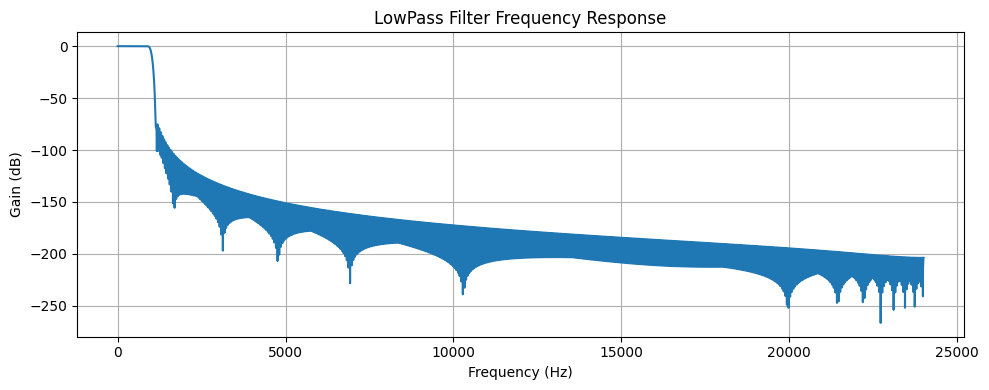

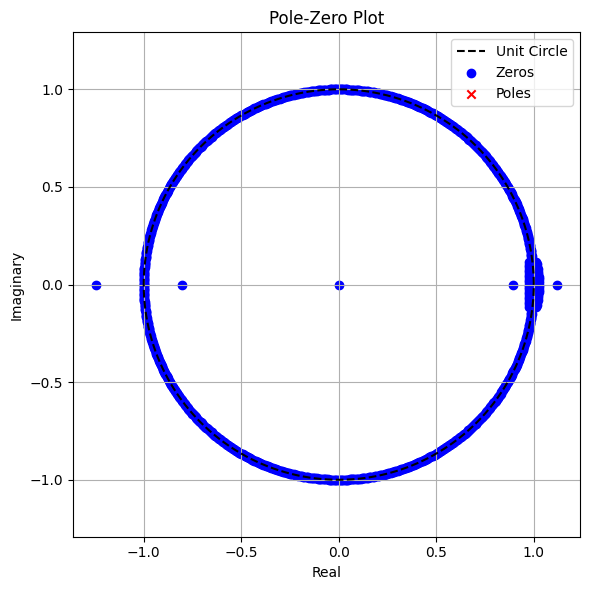

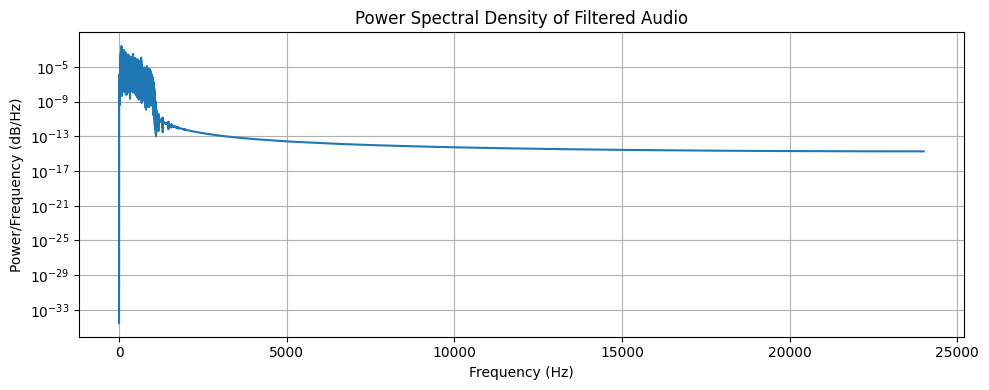

In [178]:
lowcut = 1000

nyq = 0.5 * sr
low = lowcut/nyq

numtaps = 1001 #this value was chosen on observing different values while also keeping in mind the computational cost
fir_coeffs = firwin(numtaps, low, pass_zero='lowpass', window='blackman')

y_filtered = lfilter(fir_coeffs, 1.0, y)
sf.write('lowpass_filtered.wav', y_filtered*3, sr)

#Visualising Bode-PLot
w, h = freqz(fir_coeffs, worN=10000)
plt.figure(figsize=(10, 4))
plt.plot((w / np.pi) * nyq, 20 * np.log10(abs(h)))
plt.title("LowPass Filter Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

pole_zero(fir_coeffs,[1]) #since FIR, no poles exist

# Compute Power Spectral Density
frequencies, psd = periodogram(y_filtered, sr)

# Plot PSD
plt.figure(figsize=(10, 4))
plt.semilogy(frequencies, psd) 
plt.title("Power Spectral Density of Filtered Audio")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

The Low Pass considerably suppressed the high energy of frequencies greater than 1000 Hz including the unwanted piccolo frequency, but some high frequency aspect of the vocal register is also lost leading to somewhat muffled vocals being produced and also we lost some of the high frequency harmonics.

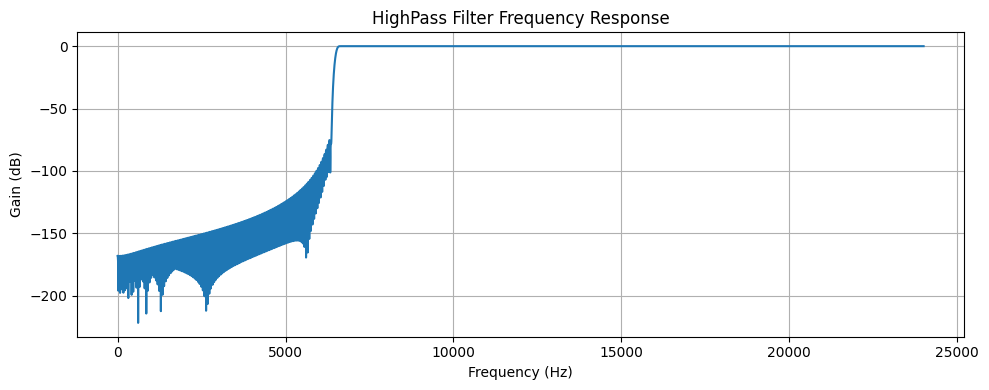

In [179]:
#High Pass filter to determine the end frequency of piccolo tune
highcut = 6500

nyq = 0.5 * sr
high = highcut/nyq


numtaps = 1001 
fir_coeffs = firwin(numtaps, high, pass_zero='highpass', window='blackman')

y_filtered = lfilter(fir_coeffs, 1.0, y)
sf.write('highpass_filtered.wav', y_filtered*2, sr)

#Visualising Bode-PLot
w, h = freqz(fir_coeffs, worN=10000)
plt.figure(figsize=(10, 4))
plt.plot((w / np.pi) * nyq, 20 * np.log10(abs(h)))
plt.title("HighPass Filter Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

The High Pass filter helped to determine the high frequency cutoff for the bandstop filter to be applied to suppress the piccolo tune. The range however of low cutoff and high cutoff somewhat covered some harmonics and vocals that will also get suppressed.

- Band Stop Filter(1000 Hz to 6500 Hz)

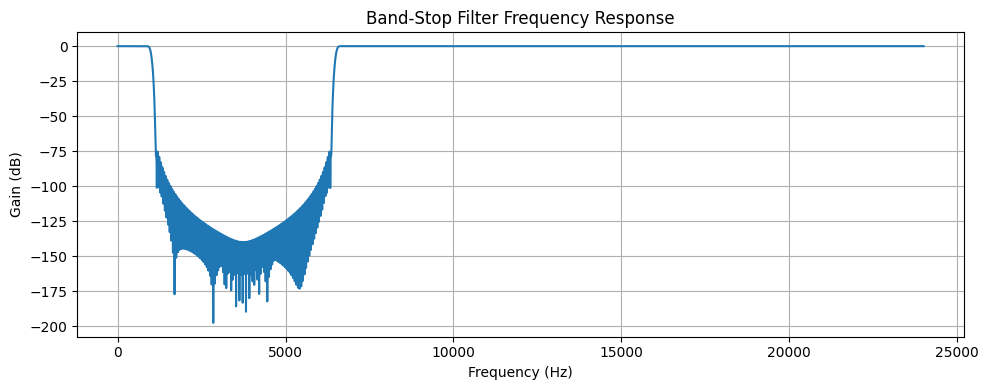

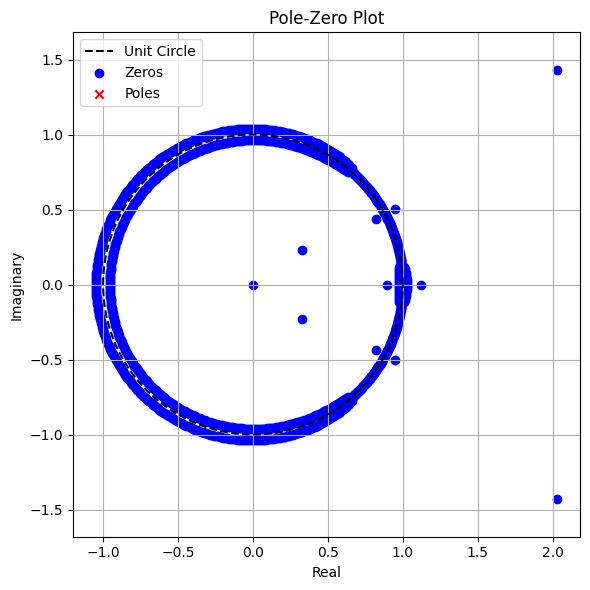

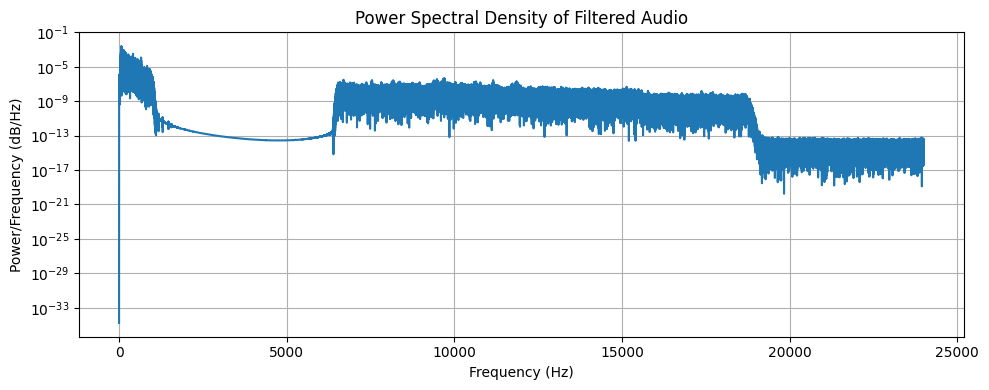

In [180]:
lowcut = 1000
highcut = 6500

nyq = 0.5 * sr
low = lowcut/nyq
high = highcut/nyq


numtaps = 1001 
fir_coeffs = firwin(numtaps, [low, high], pass_zero='bandstop', window='blackman')

y_filtered = lfilter(fir_coeffs, 1.0, y)
sf.write('bandstop_filtered.wav', y_filtered, sr)

#Visualising Bode-PLot
w, h = freqz(fir_coeffs, worN=10000)

plt.figure(figsize=(10, 4))
plt.plot((w / np.pi) * nyq, 20 * np.log10(abs(h)))
plt.title("Band-Stop Filter Frequency Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.grid(True)
plt.tight_layout()
plt.show()

#pole zero plot
b = fir_coeffs
a = [1]
pole_zero(b, a)

# Compute Power Spectral Density
frequencies, psd = periodogram(y_filtered, sr)

# Plot PSD
plt.figure(figsize=(10, 4))
plt.semilogy(frequencies, psd)  
plt.title("Power Spectral Density of Filtered Audio")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis of recovered Audio

Sample rate: 48000, Duration: 15.00 seconds


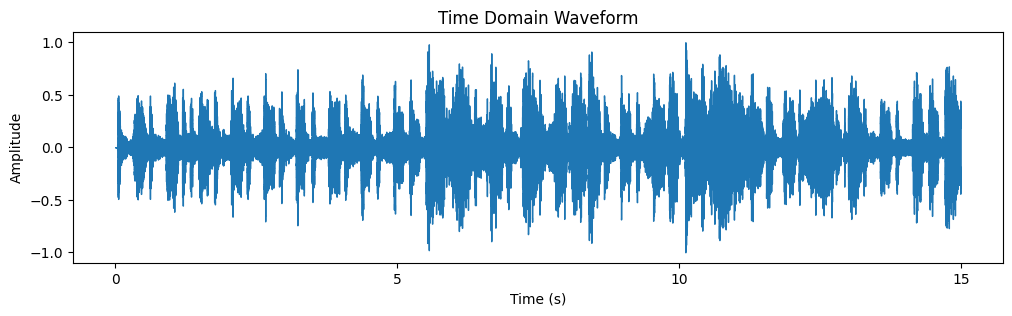

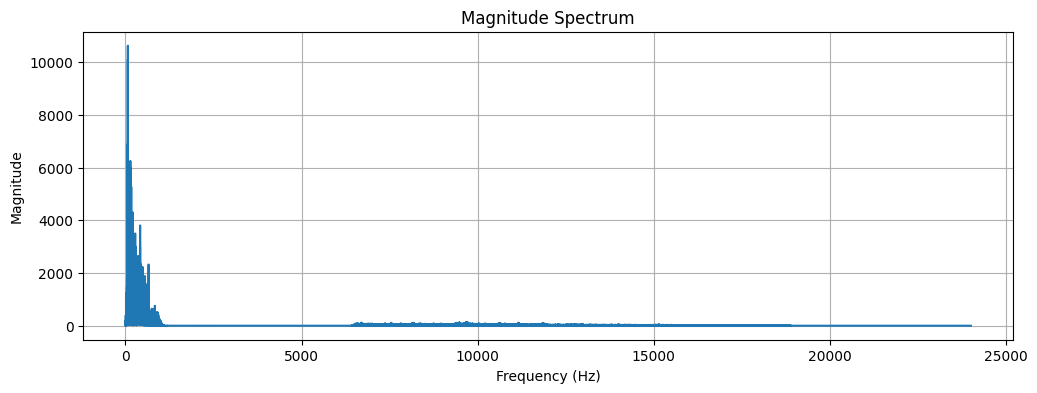

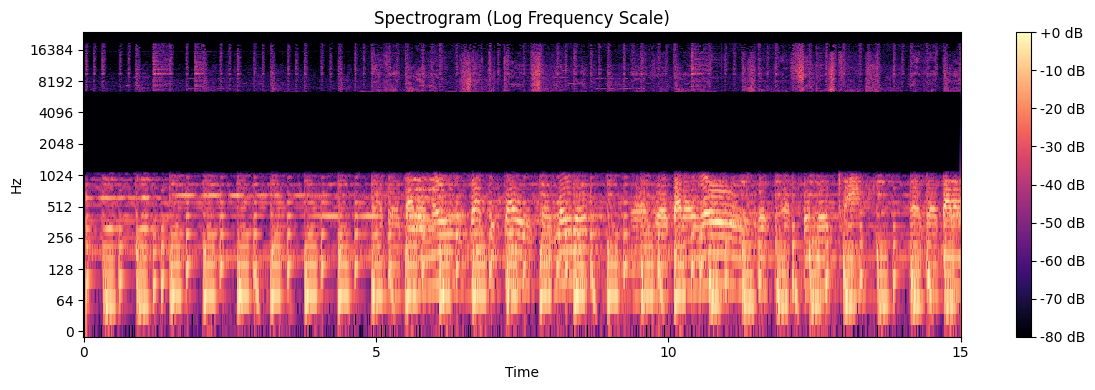

In [181]:
audio_path = 'bandstop_filtered.wav' 
y, sr = librosa.load(audio_path, sr=None)
print(f"Sample rate: {sr}, Duration: {len(y)/sr:.2f} seconds")

y = y / np.max(np.abs(y))
nyq = 0.5 * sr

plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Time Domain Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Y = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(Y), d=1/sr)

plt.figure(figsize=(12, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(Y)[:len(Y)//2])
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (Log Frequency Scale)")
plt.tight_layout()
plt.show()